# Algospeak Topic Modeling
This notebook contains some topic modeling for my algospeak project.  
This is a new, continuing script.

**Contents**
- [1 Data reshaping](#1-Data-reshaping)
- [2 K-means clustering](#2-K-means-clustering)
- [3 Topic modelling](#3-Topic-Modelling)

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
%pprint
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

Pretty printing has been turned OFF


## 1 Data reshaping
I'm only looking at the algospeak usage of terms, so I'll be looking at mention_codes a (algospeak) and m (mention)

In [2]:
unalive_df = pd.read_csv('unalive_top_posts.csv')

In [3]:
unalive_df.head()

,text,author,display_name,date,likes,quotes,replies,reposts,uri,url,reply_to,reply_to_uri,reply_to_url,query,mention_code,replace_code,topic_code
0,unalive,ninochuu.zip,nino,2025-04-12T20:19:42.329Z,154,0,0,29,at://did:plc:75rnvxji6taq2xyxq63ejhmm/app.bsky.feed.post/3lmne72jmws2d,https://bsky.app/profile/did:plc:75rnvxji6taq2xyxq63ejhmm/post/3lmne72jmws2d,No,NaN,NaN,unalive,o,NaN,unclear
1,We should unalive Caesar?,doktorslek.bsky.social,Doktor Slek 🦘☭,2025-04-15T02:50:06.393Z,10,0,0,0,at://did:plc:g7cu7736qmemcopvjip74g3b/app.bsky.feed.post/3lmt2wyd5q22a,https://bsky.app/profile/did:plc:g7cu7736qmemcopvjip74g3b/post/3lmt2wyd5q22a,Yes,at://did:plc:awzzrtrcrvpnxi3ph2sbhxwv/app.bsky.feed.post/3lmt2lhdlwk2l,https://bsky.app/profile/did:plc:awzzrtrcrvpnxi3ph2sbhxwv/post/3lmt2lhdlwk2l,unalive,a,kill,joke
2,You ever chill so hard that you appear unalive??,laminatedliss.bsky.social,Churro’s Mom,2025-04-11T15:57:19.608Z,40,1,7,1,at://did:plc:kvyauj6dn35wre6meqyg6ync/app.bsky.feed.post/3lmkf2xlja22o,https://bsky.app/profile/did:plc:kvyauj6dn35wre6meqyg6ync/post/3lmkf2xlja22o,No,NaN,NaN,unalive,a,dead,living
3,Musk can unalive any of us and cut off all means of support \nIf they can unalive these 6000,iputadollarin.bsky.social,Iputadollariniwinacar,2025-04-12T23:12:34.756Z,7,0,2,0,at://did:plc:icoabg5urmotmxr3cko3qfsi/app.bsky.feed.post/3lmnnu6fchs26,https://bsky.app/profile/did:plc:icoabg5urmotmxr3cko3qfsi/post/3lmnnu6fchs26,Yes,at://did:plc:q3bbdtxch45wvfxrxpblphxn/app.bsky.feed.post/3lmnh3qmq5c2h,https://bsky.app/profile/did:plc:q3bbdtxch45wvfxrxpblphxn/post/3lmnh3qmq5c2h,unalive,a,kill,Elon Musk
4,"That happened the moment we let these companies forced creators and content-makers to use the word ""unalive"". FUCK THAT! People die, people get killed, people commit suicide. Use words. Don't pander to that nonsense.",jayej330.bsky.social,"Jayleigh ""Jaye"" Jimenez",2025-04-14T08:57:07.765Z,29,0,1,0,at://did:plc:r6coggh5qqmqrqvrpitb7khu/app.bsky.feed.post/3lmr6ye3esc2m,https://bsky.app/profile/did:plc:r6coggh5qqmqrqvrpitb7khu/post/3lmr6ye3esc2m,Yes,at://did:plc:uqppyrcon566pkrszusjonav/app.bsky.feed.post/3lmr67dl25c2s,https://bsky.app/profile/did:plc:uqppyrcon566pkrszusjonav/post/3lmr67dl25c2s,unalive,m,NaN,censorship


In [4]:
un_am_df = unalive_df[unalive_df['mention_code'].isin(['a', 'm'])]
un_am_df[['text', 'mention_code']].sample(10)

,text,mention_code
86,They can’t bring him back to the US. Because he is unalive. And they know it. And it happened immediately. So they’re trying to squirm out of it.,a
148,wish he was unalive.,a
47,i think that if you’re in a small room with other people you should legally have to wear fucking headphones. since i’m not legally allowed to unalive you.,a
69,"Saying ""I have to unalive you now"" was a LATE choice in this movie's production, and I hope that one day we all get to truly process how much shit must have been going on amidst this thing having NINE fucking screenwriter credits",m
107,One of vlad's cars blew up in Moscow. \n\nHe's afraid one of his own soldiers might unalive his miserable ass.\n\nI love this for him. May he not know another moment of security or peace for the rest of his life. \nwww.thesun.co.uk/news/3413438...,a
42,I just wish he would come “unalive”. I don’t care who or how it happens. Enough is enough,a
188,unalive joke,a
98,He'll be 82 and will hopefully be unalive by then.,a
83,"I don't think it's okay to tell someone to unalive themselves. However, telling someone that they will suffer the consequences of their own actions, and the harm they have visited upon the world will be returned threefold? That's just factual.",a
142,Kill the Nazi within you so a democrat doesn’t have to physically unalive you out of desperation 😂,a


In [5]:
un_am_df.mention_code.value_counts()

mention_code
a    123
m     65
Name: count, dtype: int64

I will split the corpus into three sets:
- The whole corpus
- Just posts coded 'a'
- Just posts coded 'm'

In [6]:
un_docs = un_am_df.text
un_docs.head()

1                                                                                                                                                                                                   We should unalive Caesar?
2                                                                                                                                                                            You ever chill so hard that you appear unalive??
3                                                                                                                                Musk can unalive any of us and cut off all means of support \nIf they can unalive these 6000
4    That happened the moment we let these companies forced creators and content-makers to use the word "unalive". FUCK THAT! People die, people get killed, people commit suicide. Use words. Don't pander to that nonsense.
5                                                                                                               

In [7]:
a_df = unalive_df[unalive_df['mention_code'].isin(['a'])]
a_docs = a_df.text
a_docs.head()

1                                                                       We should unalive Caesar?
2                                                You ever chill so hard that you appear unalive??
3    Musk can unalive any of us and cut off all means of support \nIf they can unalive these 6000
5                                                                              I’d unalive myself
6                                                        I’m really concerned that he is unalive.
Name: text, dtype: object

In [8]:
m_df = unalive_df[unalive_df['mention_code'].isin(['m'])]
m_docs = m_df.text
m_docs.head()

4                                                  That happened the moment we let these companies forced creators and content-makers to use the word "unalive". FUCK THAT! People die, people get killed, people commit suicide. Use words. Don't pander to that nonsense.
8                                                                                                                                                                                                   >the minecraft movie features a character unironically saying "unalive"
13                                                                                                                                             I'm pretty sure someone says "unalive" instead of "kill" in the Minecraft movies without a hint of irony. \n\nWhat happened.
14    I find all of this completely ludicrous. "Unalive" - Jesus fucking Christ. It crops up all the time in autogenerated subtitles and it's driving me mental. We're devolving into fucking baby t

## 2 K-means clustering
To find the ideal amount of topics for each set of data, I will use K-means clustering. When the rate of inertia decreasing slows down or increases, that means that the ideal amount of topics has been found. 

Adapting the plot_inertia function from [Qidu's notebook](https://github.com/Data-Science-for-Linguists-2025/Chinese-English-Code-Switching-Analysis/blob/main/notebooks/2.1_analyze_data.ipynb)

In [9]:
num_feats = 1000
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=num_feats, stop_words='english')
kmeans = KMeans(n_clusters=5)
pipeline = make_pipeline(tfidf_vectorizer, kmeans)

In [10]:
import matplotlib.pyplot as plt

def plot_inertia(docs, pipeline, max_clusters=10, random_state=0):
    """
    Plots the inertia for different numbers of clusters to help identify the optimal number.

    Parameters:
    docs (series): a series of strings
    pipeline (object): A scikit-learn pipeline to be used for fitting the data.
    max_clusters (int): The maximum number of clusters to test. Default is 10.

    Returns:
    None: This function only generates and displays a plot of inertia values.
    """
    inertia = []  # List to store inertia values
    
    # Loop through different numbers of clusters
    for n in range(1, max_clusters + 1):
        # Update the pipeline with the current number of clusters
        pipeline.set_params(kmeans__n_clusters=n, 
                                kmeans__random_state=random_state)
        
        # Fit the pipeline to the data
        pipeline.fit(docs)
        
        # Get the KMeans model from the pipeline
        kmeans = pipeline.named_steps['kmeans']
        
        # Append the inertia value for the current model
        inertia.append(kmeans.inertia_)
    
    # Plot inertia to visualize the optimal number of clusters
    plt.figure(figsize=(8, 5))
    ax = plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('KMeans Inertia')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    return ax

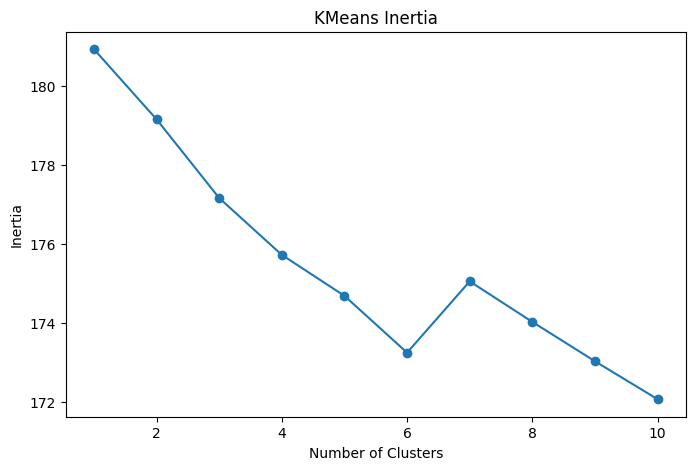

In [11]:
plot = plot_inertia(un_docs, pipeline, max_clusters=10)
plt.savefig('plots/inertia_all.png')

Seems like 6 is the correct number of topics for all of the unalive data

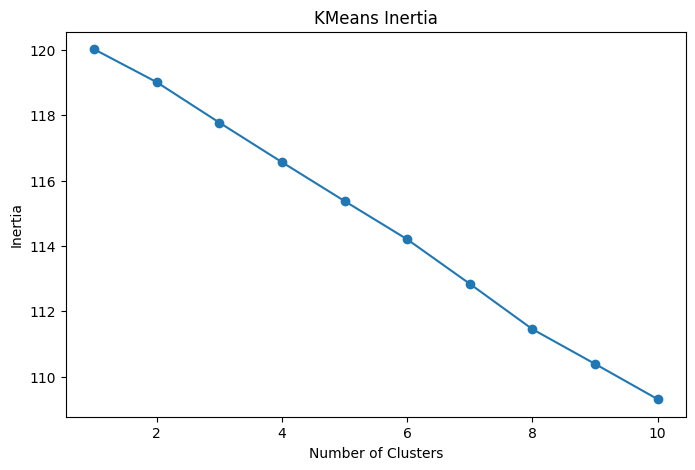

In [12]:
# Just a codes
plot = plot_inertia(a_docs, pipeline, max_clusters=10)
plt.savefig('plots/inertia_a.png')

This is less clear, but maybe 8 topics?

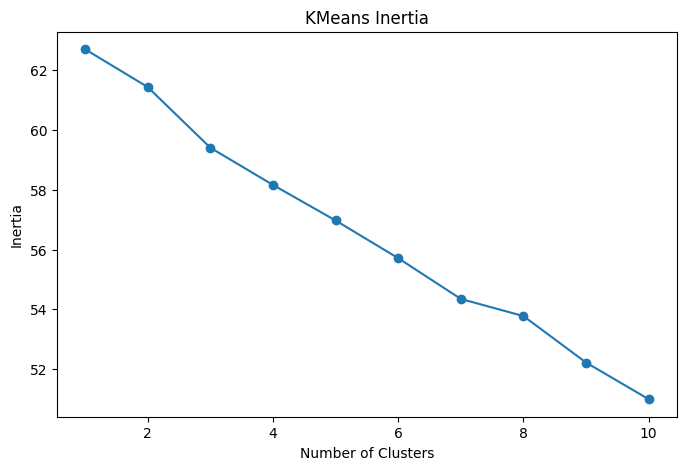

In [13]:
# Just m codes
plot = plot_inertia(m_docs, pipeline, max_clusters=10)
plt.savefig('plots/inertia_m.png')

8 topics again!

## 3 Topic Modelling
I will be modelling the topics for all unalive posts, just the posts with a codes, and just the posts with m codes.

In [14]:
# Na-rae's function
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [15]:
num_feats = 1000
num_topics = 6

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=num_feats, stop_words='english')
tfidf_docs = tfidf_vectorizer.fit_transform(un_docs)

nmf_model = NMF(n_components=num_topics, random_state=1, l1_ratio=.5, 
                init='nndsvd').fit(tfidf_docs)

display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), 10)

Topic 0:
people like say words trying kill just tiktok use way
Topic 1:
character chungus named general said movie word minecraft say tells
Topic 2:
don know time just wish really want telling live care
Topic 3:
gonna minecraft unaliving sweaty hate fucking pew say straight movie
Topic 4:
going somebody make right let hard life ups pop constant
Topic 5:
ll hope shit wrong picking wildlife critter tourists love news


In [16]:
num_feats = 1000
num_topics = 8

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=num_feats, stop_words='english')
tfidf_docs = tfidf_vectorizer.fit_transform(a_docs)

nmf_model = NMF(n_components=num_topics, random_state=1, l1_ratio=.5, 
                init='nndsvd').fit(tfidf_docs)

display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), 10)

Topic 0:
people think trying like allowed tell trans hate legally fucking
Topic 1:
going somebody let reason hard make good impact question regret
Topic 2:
really concerned know sorry stuff moment actually instructed harry deflect
Topic 3:
fucker fuck right thing fat wants try bring fact bullshit
Topic 4:
wish don want care just come happens time government reason
Topic 5:
hope ll literally book deserves hounded throw 82 hopefully social
Topic 6:
trump touches life miserable risk making coming having hitler hated
Topic 7:
gonna unaliving highkey sweaty doesn minecraft blooded hear believing hot


In [17]:
num_feats = 1000
num_topics = 8

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=num_feats, stop_words='english')
tfidf_docs = tfidf_vectorizer.fit_transform(m_docs)

nmf_model = NMF(n_components=num_topics, random_state=1, l1_ratio=.5, 
                init='nndsvd').fit(tfidf_docs)

display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), 10)

Topic 0:
chungus character named general said say word tells called instead
Topic 1:
like say shit things pew murder kill people gonna bullshit
Topic 2:
minecraft movie saying features unironically sure character movies gonna im
Topic 3:
use words people content creators tiktok youtube video suicide places
Topic 4:
hate sewer slide sounds childish forever fucking term straight im
Topic 5:
just bikini word new dropped saw euphemism silly sanest cutest
Topic 6:
don live know telling omg keeps dude write actually moonshine
Topic 7:
la en por que inglés vez rrss poco inducción dice


C:\Users\sara9\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
